## Brain Tumor Classification


### Clone the Github Repo to access the Dataset


### Import necessary Libraries 


In [1]:
import torch, os, random
## from tqdm import tqdm
## import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
## import seaborn as sns
## import cv2
## from IPython.display import Image
## import imutils
## import torchvision

from kcn import ConvNeXtKAN

# Hope you don't be imprisoned by legacy Python code :)
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
## from torchvision.transforms import functional as F
## from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## import tensorflow.keras as keras
## from tensorflow.keras.models import Sequential

## import tensorflow as tf
## from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
## from tensorflow.keras.applications import EfficientNetB1
## from tensorflow.keras.models import Model
## from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
## from tensorflow.keras.optimizers import Adam

try:
    model_name
except NameError:
    model_name = 'ConvNeXtKAN'

if torch.cuda.is_available():
    print("Cuda is here!")
else:
    print("Cuda is not here :( ")


2024-08-08 15:02:01.121839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 15:02:01.143668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 15:02:01.150409: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-08 15:02:01.166540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 15:02:02.156430: W tensorflow/compiler/tf2

Cuda is here!



### Data Visualization


In [2]:
files_path_dict = {}

# `cwd`: current directory is straightforward
cwd = Path.cwd()

train_dir = str(cwd) + "/data/Training"
test_dir = str(cwd) + "/data/Testing"

data_training = {
    'glioma_tumor': [],
    'meningioma_tumor': [],
    'no_tumor': [],
    'pituitary_tumor': []
}
for i in data_training.keys():
    for j in os.listdir(train_dir + "/" + i):
        data_training[i].append(f"{train_dir}/{i}/{j}")

data_testing = {
    'glioma_tumor': [],
    'meningioma_tumor': [],
    'no_tumor': [],
    'pituitary_tumor': []
}
for i in data_testing.keys():
    for j in os.listdir(test_dir + "/" + i):
        data_testing[i].append(f"{test_dir}/{i}/{j}")

len_train = {}
for i in data_training.keys():
    len_train[i] = len(data_training[i])
len_testing = {}
for i in data_testing.keys():
    len_testing[i] = len(data_testing[i])

print({"training": len_train, "testing": len_testing})


{'training': {'glioma_tumor': 8239, 'meningioma_tumor': 4621, 'no_tumor': 4621, 'pituitary_tumor': 4219}, 'testing': {'glioma_tumor': 2269, 'meningioma_tumor': 2250, 'no_tumor': 2340, 'pituitary_tumor': 2311}}


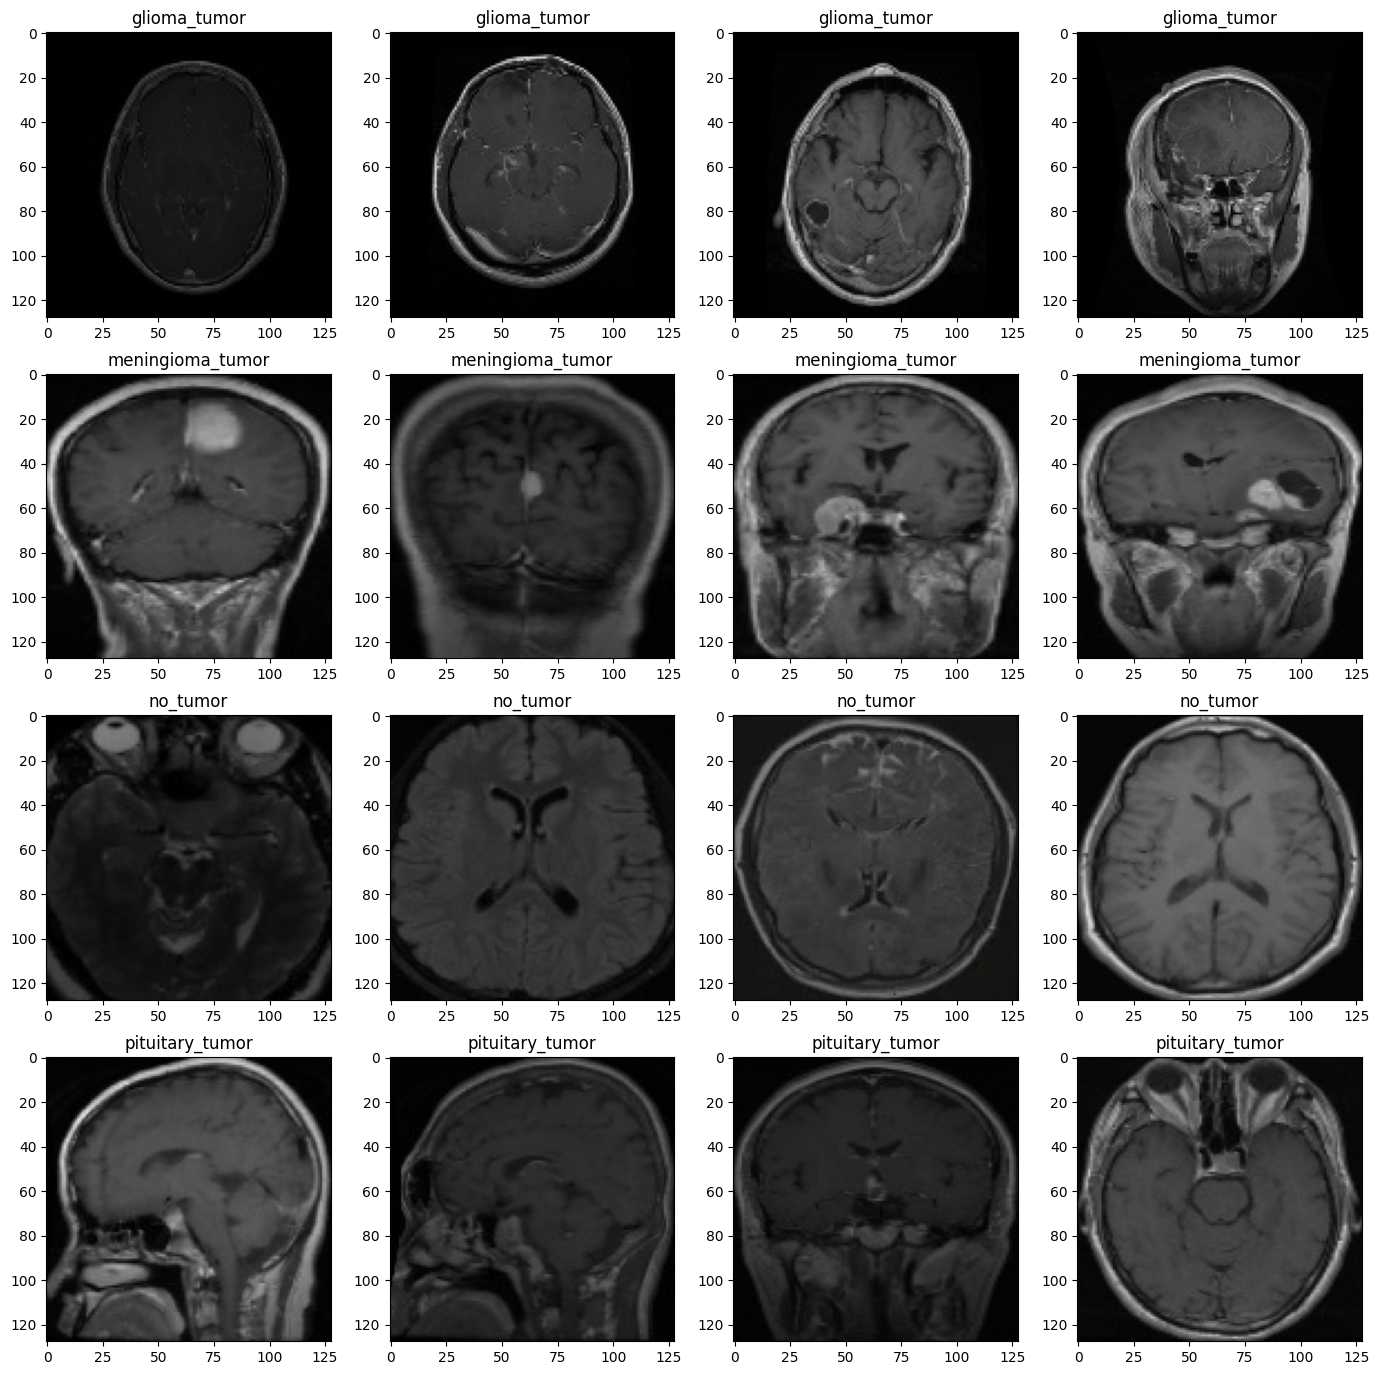

In [3]:
plt.figure(figsize=(17, 17))
index = 0
for c in data_training.keys():
    random.shuffle(data_training[c])
    path_list = data_training[c][:5]

    for i in range(1, 5):
        index += 1
        plt.subplot(4, 4, index)
        plt.imshow(load_img(path_list[i]))
        plt.title(c)


### Data Augmentation


In [4]:
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0, 0.2)),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

valid_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Split the training data into training and validation sets
num_train = len(train_dataset)
split = int(0.8 * num_train)  # 80% training, 20% validation
train_size = split
valid_size = num_train - split

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
"train: ", len(train_dataset), "Valid: ", len(valid_dataset), "test: ", len(test_dataset)

('train: ', 17360, 'Valid: ', 4340, 'test: ', 9170)

### Model Architect


### Compile Model


In [5]:
# Instancujte model
model = ConvNeXtKAN()

if torch.cuda.is_available():
    model.cuda()

# Vytiskněte souhrn modelu
def print_model_summary(model, input_size=(3, 128, 128)):
    from torchsummary import summary
    summary(model, input_size=input_size)


print_model_summary(model)

# print_model_summary(model)
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.CrossEntropyLoss()


/home/semillerolun/miniconda3/envs/kan/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/semillerolun/miniconda3/envs/kan/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConvNeXtKAN(
  (convnext): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,

### Model Training and Model Evaluation


In [6]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_score = None
        self.early_stop_counter = 0
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model_wts = model.state_dict()
        elif val_loss < self.best_score:
            self.best_score = val_loss
            self.best_model_wts = model.state_dict()
            self.early_stop_counter = 0
        else:
            self.early_stop_counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.early_stop_counter} out of {self.patience}')
            if self.early_stop_counter >= self.patience:
                if self.verbose:
                    print('Early stopping')
                model.load_state_dict(self.best_model_wts)
                return True
        return False

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=2, verbose=True)

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

/home/semillerolun/miniconda3/envs/kan/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
%%time

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import numpy as np

accuracy_training = []
accuracy_testing = []
loss_validation = []
loss_training = []

try:
    num_epoch
except NameError:
    num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_acc = 0

    # Training loop with progress bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:

            if torch.cuda.is_available():
                inputs = inputs.to(torch.device('cuda'))
                labels = labels.to(torch.device('cuda'))

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            pbar.set_postfix(loss=running_loss / (total + 1e-8), accuracy=correct / total)
            pbar.update()

    # logging 
    accuracy_training.append(epoch_acc)
    loss_training.append(epoch_loss)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}')

    accuracy_training.append(epoch_acc)
    loss_training.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Validation loop with progress bar
    with tqdm(total=len(valid_loader), desc='Validation', unit='batch') as pbar:
        with torch.no_grad():
            for inputs, labels in valid_loader:

                if torch.cuda.is_available():
                    inputs = inputs.to(torch.device('cuda'))
                    labels = labels.to(torch.device('cuda'))

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # Update progress bar
                pbar.set_postfix(val_loss=val_loss / (val_total + 1e-8), val_accuracy=val_correct / val_total)
                pbar.update()

    val_loss = val_loss / len(valid_dataset)
    val_acc = val_correct / val_total
    print(f'Validation Loss: {val_loss:.4f} - Accuracy: {val_acc:.4f}')

    loss_validation.append(val_loss)
    accuracy_testing.append(val_acc)

    # Step the scheduler
    scheduler.step(val_acc)

    # Check early stopping
    if early_stopping(val_loss, model):
        num_epochs = epoch
        break

Epoch 1/5: 100%|█████████████████████████████████████████████| 543/543 [01:34<00:00,  5.77batch/s, accuracy=0.793, loss=0.542]


Epoch 1/5 - Loss: 0.5423 - Accuracy: 0.7927


Validation: 100%|█████████████████████████████████████| 136/136 [00:24<00:00,  5.59batch/s, val_accuracy=0.87, val_loss=0.347]


Validation Loss: 0.3469 - Accuracy: 0.8700


Epoch 2/5: 100%|█████████████████████████████████████████████| 543/543 [01:33<00:00,  5.82batch/s, accuracy=0.864, loss=0.366]


Epoch 2/5 - Loss: 0.3655 - Accuracy: 0.8642


Validation: 100%|████████████████████████████████████| 136/136 [00:22<00:00,  6.01batch/s, val_accuracy=0.902, val_loss=0.275]


Validation Loss: 0.2746 - Accuracy: 0.9023


Epoch 3/5: 100%|█████████████████████████████████████████████| 543/543 [01:33<00:00,  5.83batch/s, accuracy=0.886, loss=0.311]


Epoch 3/5 - Loss: 0.3112 - Accuracy: 0.8857


Validation: 100%|████████████████████████████████████| 136/136 [00:22<00:00,  5.99batch/s, val_accuracy=0.904, val_loss=0.265]


Validation Loss: 0.2647 - Accuracy: 0.9039


Epoch 4/5: 100%|█████████████████████████████████████████████| 543/543 [01:32<00:00,  5.84batch/s, accuracy=0.897, loss=0.273]


Epoch 4/5 - Loss: 0.2729 - Accuracy: 0.8974


Validation: 100%|████████████████████████████████████| 136/136 [00:22<00:00,  5.93batch/s, val_accuracy=0.912, val_loss=0.238]


Validation Loss: 0.2376 - Accuracy: 0.9115


Epoch 5/5: 100%|█████████████████████████████████████████████| 543/543 [01:33<00:00,  5.84batch/s, accuracy=0.904, loss=0.252]


Epoch 5/5 - Loss: 0.2516 - Accuracy: 0.9045


Validation: 100%|████████████████████████████████████| 136/136 [00:22<00:00,  5.99batch/s, val_accuracy=0.921, val_loss=0.216]

Validation Loss: 0.2162 - Accuracy: 0.9214
CPU times: user 1h 49min 4s, sys: 6min 55s, total: 1h 55min 59s
Wall time: 9min 41s


In [19]:

from common import update_json_with_key

update_json_with_key('data.json', model_name, num_epochs, accuracy_training, accuracy_testing, loss_training,
                     loss_validation)


AttributeError: 'list' object has no attribute 'tolist'

In [8]:
from common import save_checkpoint

save_checkpoint(model, optimizer, model_name + "_checkpoint.pth", num_epochs)

### Model Evaluation


In [9]:
from common import load_checkpoint

model = ConvNeXtKAN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model, optimizer, num_epochs = load_checkpoint(model, optimizer, model_name + "_checkpoint.pth", )


/home/semillerolun/kan/common.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)


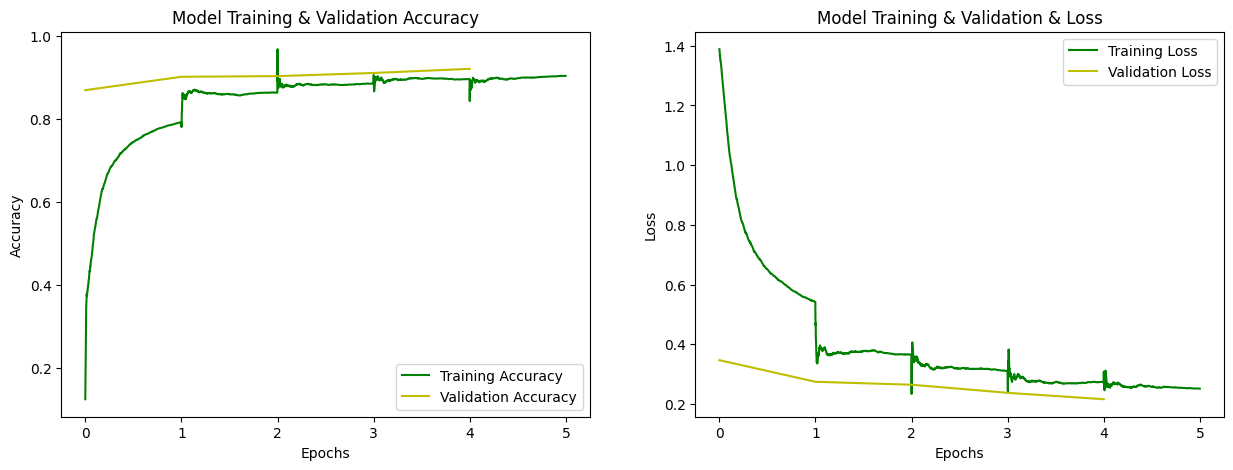

In [10]:

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

epochs = np.arange(0, num_epochs, num_epochs / len(accuracy_training))

ax[0].plot(epochs, accuracy_training, 'g', label='Training Accuracy')

epochs = np.arange(0, num_epochs, num_epochs / len(accuracy_testing))

ax[0].plot(epochs, accuracy_testing, 'y-', label='Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc='lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
epochs = np.arange(0, num_epochs, num_epochs / len(loss_training))

ax[1].plot(epochs, loss_training, 'g', label='Training Loss')

epochs = np.arange(0, num_epochs, num_epochs / len(loss_validation))

ax[1].plot(epochs, loss_validation, 'y-', label='Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.savefig(model_name + ".svg")
